In [16]:
%pylab inline
import pandas as pd

# loading MNIST training data
mnist_train = pd.read_csv('train.csv')
mnist_train.head(5)

Populating the interactive namespace from numpy and matplotlib


C:\Users\tshan_19f6h3m\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Display one of each digit.

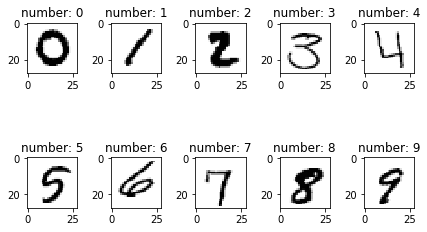

In [17]:
from matplotlib import pylab as plot

def displayDigitTable():
    for digit in range(10):
        row = 0
        while mnist_train.label[row] != digit:
            row += 1 
        digitTable = plot.subplot(2, 5, (digit+1))
        digitTable.set_title("number: %d" % digit)
        digitTable.imshow(mnist_train.iloc[row][1:].values.reshape(28,28), cmap=cm.binary)
    plot.tight_layout()

displayDigitTable()

#### Examining the prior probability of the different digits: 
The distribution of digits is not even. Ones appear most frequently and fives appear least frequently. 

C:\Users\tshan_19f6h3m\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


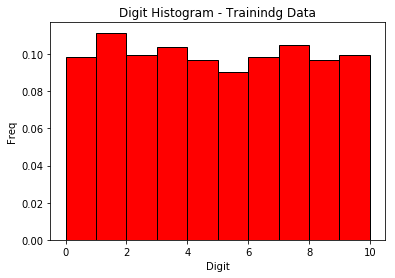

In [18]:
def displayDigitHistogram():
    plot.hist(mnist_train.label, bins = range(11), color='red', edgecolor='black', linewidth=1, normed=1)
    plot.xlabel("Digit")
    plot.ylabel("Freq")
    plot.title("Digit Histogram - Trainindg Data")
displayDigitHistogram()

#### Finding nearest neighbor (L2 distance) for example digits: 

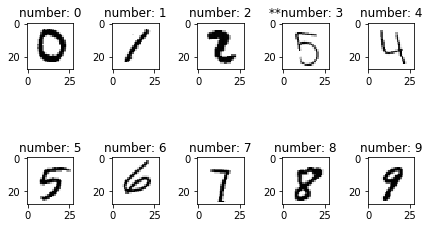

In [9]:
def findNearestNeighboor(row):
    closestVal = float('inf')
    closetRow = 0
    for i in range(len(mnist_train)):
        if i != row:
            euclidean_distance = numpy.linalg.norm(mnist_train.iloc[row]-mnist_train.iloc[i])
            if euclidean_distance < closestVal:
                closestVal = euclidean_distance
                closetRow = i
    return closetRow

def displayClosestTable():
    closestRow = [None]*10
    for digit in range(10):
        row = 0
        while mnist_train.label[row] != digit:
            row += 1 
        closestRow[digit] = findNearestNeighboor(row)
    
    for i in range(len(closestRow)):
        digitTable = plot.subplot(2, 5, (i+1))
        if i != mnist_train.label[closestRow[i]]: 
            digitTable.set_title("**number: %d" % i)
        else: 
            digitTable.set_title("number: %d" % i)
        digitData = array([mnist_train.iloc[closestRow[i]][1:]])
        digitTable.imshow(digitData.reshape(28,28), cmap=cm.binary)
    plot.tight_layout()

displayClosestTable()


#### Computing the pairwise distances for all genuine matches and all impostor matches, again using the L2 norm, and ploting histograms of the genuine and impostor distances:

C:\Users\tshan_19f6h3m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


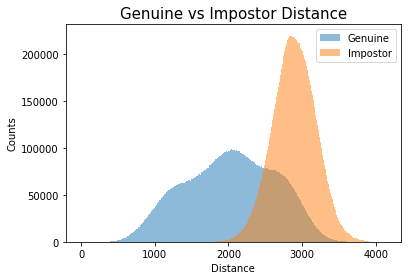

In [24]:
import sklearn.metrics.pairwise as pw
from matplotlib import pyplot

# prepare zero-one data
zero_one = mnist_train[mnist_train.label <= 1]
zero_one.sort_values(by=['label'],inplace=True) 
value_count = zero_one.groupby('label').size()
zero_one = zero_one.drop('label', axis = 1)

# generate matrix of all pairwise distances
distance_matrix = pw.pairwise_distances(zero_one)

# prepare TP, FP matrices
true_zero = distance_matrix[:value_count[0],:value_count[0]].reshape(value_count[0]**2)
true_one = distance_matrix[value_count[0]:,value_count[0]:].reshape(value_count[1]**2)
false_zero = distance_matrix[:value_count[0],value_count[0]:].reshape(value_count[0]*value_count[1])
false_one = distance_matrix[value_count[0]:,:value_count[0]].reshape(value_count[0]*value_count[1])
genuine = append(true_zero,true_one)
impostor = append(false_zero,false_one)

# plot data
bins = numpy.linspace(0, value_count[0], 1000)
pyplot.hist(genuine, bins, alpha=0.5, label='Genuine')
pyplot.hist(impostor, bins, alpha=0.5, label='Impostor')
pyplot.legend(loc='upper right')
pyplot.xlabel('Distance')
pyplot.ylabel('Counts')
pyplot.title('Genuine vs Impostor Distance', fontsize = 15)
pyplot.show()

#### Generating an ROC curve from the above sets of distances:

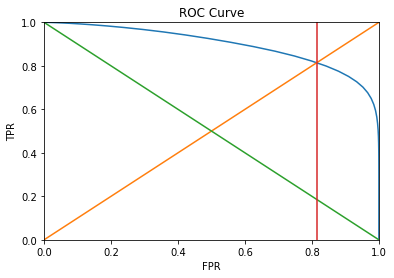

In [22]:
from collections import Counter 
import numpy

tpr,fpr = [],[]
true_counter, false_counter = Counter(genuine), Counter(impostor)

# counting observations that fall above/below threshold 
for dist_bucket in range(0,math.ceil(max(max(genuine),max(impostor)))+50,50):  
    tp,tn,fp,fn = 0,0,0,0
    
    for dist_val in false_counter:
        if dist_val > dist_bucket:
            fp += int(false_counter.get(dist_val))
        else:
            tn += int(false_counter.get(dist_val))
            
    for dist_val in true_counter:
        if dist_val > dist_bucket:
            fn += int(true_counter.get(dist_val))
        else:
            tp += int(true_counter.get(dist_val))

    tprate = (tp/(tp+fn))
    fprate = (fp/(fp+tn))
   
    tpr.append(tprate)
    fpr.append(fprate)

pyplot.plot(fpr, tpr)
pyplot.plot([0, 1], [0, 1])
pyplot.plot([0, 1], [1, 0])
pyplot.plot([.815, .815], [0, 1])
pyplot.xlim([0, 1])
pyplot.ylim([0, 1])
pyplot.title('ROC Curve')
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

#### Experimenting with non-library K-NN classifier:

In [12]:
import random 
import numpy

def KNN(targetDigit, trainingData, neighborCount):
    distance_label = []
    for digit in range(len(trainingData)):
        distance = numpy.linalg.norm(trainingData.iloc[digit][1:]-targetDigit)
        distance_label.append([distance, trainingData.iloc[digit,0]])
    distance_label.sort(key=lambda x:x[0])
    labelList = [label[1] for label in distance_label][0:neighborCount]
    random.shuffle(labelList) # in the event of tie, max function returns the first max it encounters. shuffling the list creates random outcome in the event of tie
    return max(set(labelList), key = labelList.count) 

#### Using the training data for all digits, performed 3 fold cross-validation on K-NN classifier:
Yeilds an average accuracy of 96.54%

In [45]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

def crossValidation(trainingData, splits, knnCount):
    label_predict, label_actual = [], []
    count, correct = 0,0
    cols = trainingData.columns
    kf = KFold(n_splits=splits, shuffle=False) 
    neigh = KNeighborsClassifier(n_neighbors=knnCount)
    for train_index, test_index in kf.split(trainingData):
        train_fold = trainingData.iloc[train_index,1:].values.tolist()
        train_label = trainingData.iloc[train_index,0].values.tolist()
        test_fold = trainingData.iloc[test_index].drop('label',axis=1).values.tolist()
        test_label = pd.DataFrame(trainingData.iloc[test_index,0])

        # running KNN on folds
        neigh.fit(train_fold, train_label) 
        for digit in range(len(test_fold)):
            count += 1
            prediction = neigh.predict(array(test_fold[digit]).reshape(1, -1))
            label_predict.append(prediction)
            label_actual.append(test_label.iloc[digit][0])
            if prediction == test_label.iloc[digit,0]:
                correct += 1
    print("Average accuracy: ",correct/count)
    return [label_predict,label_actual]

#### Generating a confusion matrix:

Average accuracy:  0.9654285714285714


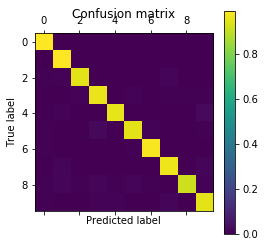

In [46]:
from sklearn.metrics import confusion_matrix

cross_validation_data = crossValidation(mnist_train, 3, 3)
confusion_matrix = confusion_matrix(cross_validation_data[1], cross_validation_data[0])
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

pyplot.matshow(confusion_matrix)
pyplot.title('Confusion matrix')
pyplot.colorbar()
pyplot.ylabel('True label')
pyplot.xlabel('Predicted label')
pyplot.savefig('confusion_matrix.png')
pyplot.show()

#### Training classifier with all of the training data, and testing your classifier with test data:

In [47]:
# loading MNIST training data
mnist_test = pd.read_csv('test.csv')

# creating and filling dataframe
predict_values = pd.DataFrame(columns=['ImageId','Label'])

training_data = pd.DataFrame(mnist_train.iloc[:,1:]).values.tolist()
training_label = pd.DataFrame(mnist_train.iloc[:,0]).values.tolist()

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(training_data, training_label) 

for digit in range(0,len(mnist_test)): 
    predict_values.loc[digit] = ([digit+1,neigh.predict(array(mnist_test.iloc[digit]).reshape(1, -1))[0]])
    
#writing to file
predict_values.to_csv('results.csv', index = False)
print("done")

C:\Users\tshan_19f6h3m\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


done
